In [ ]:
#!pip install tensorflow-gpu

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d danielwillgeorge/glove6b100dtxt

 93% 122M/131M [00:02<00:00, 31.5MB/s]
100% 131M/131M [00:02<00:00, 50.7MB/s]


In [ ]:
!unzip glove6b100dtxt.zip -d glove100

Archive:  glove6b100dtxt.zip
  inflating: glove100/glove.6B.100d.txt  


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
max_seq_len = 100
max_vocab_size = 20000
epochs = 1000
batch_size = 64
embedding_dim = 100
validation_split = 0.2
latent_dim = 50

In [ ]:
input_txts = []
target_txts = []

In [ ]:
for line in open('robert_frost.txt'):
  
  line = line.strip()
  input_line = '<SOS> ' + line
  target_line = line + ' <EOS>'

  input_txts.append(input_line)
  target_txts.append(target_line)

all_lines = input_txts + target_txts

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_txts)
target_sequences = tokenizer.texts_to_sequences(target_txts)

In [ ]:
max_seq_len_lines = max(len(s) for s in all_lines)
max_seq_len_lines

64

In [ ]:
word2index = tokenizer.word_index
print(len(word2index))

3056


In [ ]:
assert '<sos>' in word2index
assert '<eos>' in word2index

In [ ]:
max_seq_len = min(max_seq_len, max_seq_len_lines)
max_seq_len

64

In [ ]:
input_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')

In [ ]:
input_sequences.shape

(1581, 64)

In [ ]:
target_sequences.shape

(1581, 64)

In [ ]:
word_embeddings = {}
with open(os.path.join('/content/glove100/glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word_key = values[0]
        word_vector = np.array(values[1:], dtype='float32')
        
        word_embeddings[word_key] = word_vector

In [ ]:
num_words = min(max_vocab_size, len(word2index)+1)
num_words

3057

In [ ]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, idx in word2index.items():
    if idx < max_vocab_size:
        embedding_vector = word_embeddings.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

In [ ]:
one_hot_targets = np.zeros((len(target_sequences), max_seq_len, num_words))
for i, target_sequence in enumerate(target_sequences):
  for j, token_id in enumerate(target_sequence):
      if token_id > 0:
        one_hot_targets[i, j, token_id] = 1

one_hot_targets.shape

(1581, 64, 3057)

In [60]:
max_seq_len

64

In [ ]:
embedding_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix] ,input_length=max_seq_len)

input_ = tf.keras.Input(shape=(max_seq_len,))
x = embedding_layer(input_)

initial_h = tf.keras.Input(shape=(latent_dim,))
initial_c = tf.keras.Input(shape=(latent_dim,))

lstm = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])

dense = tf.keras.layers.Dense(units=num_words, activation='softmax')
output_ = dense(x)

model = tf.keras.models.Model(inputs=[input_, initial_h, initial_c], outputs=output_)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
z = np.zeros((len(input_sequences), latent_dim))

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=25, 
    restore_best_weights=True,
)

history = model.fit(x=[input_sequences, z, z], y=one_hot_targets, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/1000
20/20 [==============================] - 9s 82ms/step - loss: 0.9515 - accuracy: 0.0163 - val_loss: 0.9992 - val_accuracy: 0.0155
Epoch 2/1000
20/20 [==============================] - 1s 52ms/step - loss: 0.8887 - accuracy: 0.0156 - val_loss: 0.9255 - val_accuracy: 0.0156
Epoch 3/1000
20/20 [==============================] - 1s 50ms/step - loss: 0.8251 - accuracy: 0.0156 - val_loss: 0.8938 - val_accuracy: 0.0156
Epoch 4/1000
20/20 [==============================] - 1s 51ms/step - loss: 0.8135 - accuracy: 0.0156 - val_loss: 0.8927 - val_accuracy: 0.0156
Epoch 5/1000
20/20 [==============================] - 1s 51ms/step - loss: 0.8118 - accuracy: 0.0156 - val_loss: 0.8896 - val_accuracy: 0.0156
Epoch 6/1000
20/20 [==============================] - 1s 52ms/step - loss: 0.8077 - accuracy: 0.0156 - val_loss: 0.8856 - val_accuracy: 0.0156
Epoch 7/1000
20/20 [==============================] - 1s 51ms/step - loss: 0.8035 - accuracy: 0.0156 - val_loss: 0.8826 - val_accuracy: 0.0156

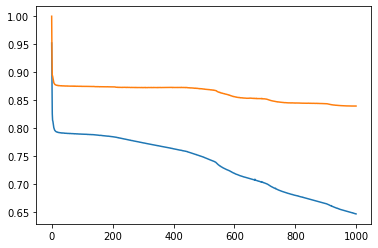

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

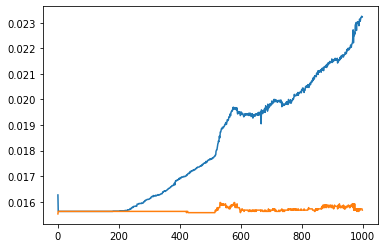

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [34]:
input_2 = tf.keras.Input(shape=(1,))
x = embedding_layer(input_2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
model_2 = tf.keras.models.Model(inputs=[input_2, initial_h, initial_c], outputs=[output2, h, c])

In [43]:
index2word = {v:k for k,v in word2index.items()}

In [44]:
index2word[3056]

'sport.'

In [56]:
def generate_line():

  singleword_input = np.array([[word2index['<sos>']]])
  h = np.zeros((1, latent_dim))
  c = np.zeros((1, latent_dim))

  eos = word2index['<eos>']
  final_seq = []

  for _ in range(max_seq_len):
    o, h, c = model_2.predict(x=[singleword_input, h, c])

    pred_probs = o[0,0]
    pred_probs[0] = 0
    pred_probs /= pred_probs.sum()

    new_wordidx = np.random.choice(len(pred_probs), p=pred_probs)
    if new_wordidx == eos:
      break

    sampled_word = index2word.get(new_wordidx)
    final_seq.append(sampled_word)
    
    singleword_input[0,0] = word2index[sampled_word]

  return ' '.join(final_seq)

In [57]:
generate_line()

'struck what- her single knew bulkhead double-doors sky coat gnawed this. without is does'

In [51]:
word2index['one,']

427